In [1]:
from gensim.models import Word2Vec

In [2]:
%time model = Word2Vec.load("word2vecBM.model")

Wall time: 531 ms


In [3]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 24132


In [4]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 150 #100
VALIDATION_SPLIT = 0.1

In [5]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
#os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

Using TensorFlow backend.


In [6]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [7]:
# reading data
df = pd.read_excel('WSD_Dictionary.xlsx')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['Sense_Index'])))
print('No. of tokens',df['Sense_Example'].apply(lambda x: len(x.split(' '))).sum())

Shape of dataset  (104, 4)
Index(['Words', 'Sense_Index', 'Sense_Description', 'Sense_Example'], dtype='object')
No. of unique classes 104
No. of tokens 850


In [8]:
macronum=sorted(set(df['Sense_Index']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['class']=df['Sense_Index'].apply(fun)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
Words                104 non-null object
Sense_Index          104 non-null object
Sense_Description    104 non-null object
Sense_Example        104 non-null object
class                104 non-null int64
dtypes: int64(1), object(4)
memory usage: 4.1+ KB


In [10]:
texts = []
labels = []

for idx in range(df.Sense_Description.shape[0]):
    text = BeautifulSoup(df.Sense_Description[idx],"lxml")
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['class']:
    labels.append(idx)

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 244


In [12]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (104, 1000)
Shape of Label Tensor: (104, 104)


In [13]:
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, EMBEDDING_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass

In [14]:
embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[wv_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [15]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(150))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 150)         3619800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               361200    
_________________________________________________________________
dense_1 (Dense)              (None, 104)               31304     
Total params: 4,012,304
Trainable params: 4,012,304
Non-trainable params: 0
_________________________________________________________________


In [16]:
cp=ModelCheckpoint('model_lstm.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
%time history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=20, batch_size=32, callbacks=[cp])

Train on 94 samples, validate on 10 samples
Epoch 1/20
94/94 [==============================] - 25s 267ms/step - loss: 4.6611 - acc: 0.0106 - val_loss: 4.6950 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to model_lstm.hdf5
Epoch 2/20
94/94 [==============================] - 19s 197ms/step - loss: 4.6345 - acc: 0.0000e+00 - val_loss: 4.7480 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/20
94/94 [==============================] - 18s 197ms/step - loss: 4.6171 - acc: 0.0319 - val_loss: 4.8118 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/20
94/94 [==============================] - 18s 194ms/step - loss: 4.5996 - acc: 0.0745 - val_loss: 4.8935 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/20
94/94 [==============================] - 18s 197ms/step - loss: 4.5808 - acc: 0.0532 - val_loss: 5.0212 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not

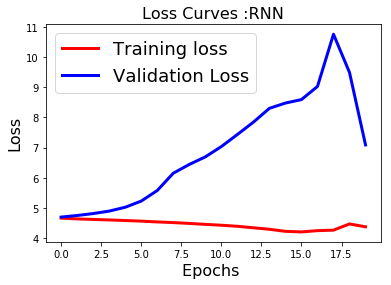

In [17]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

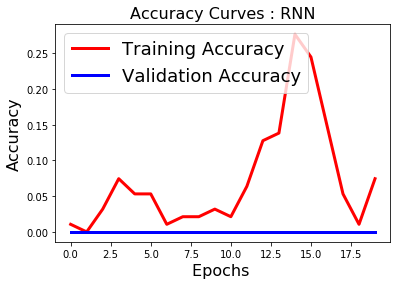

In [18]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

In [19]:
score = model.evaluate(x_val, y_val,
                       batch_size=2, verbose=1)
print('Test accuracy:', score[1])

10/10 [==============================] - 1s 77ms/step
Test accuracy: 0.0
